In [1]:
# import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np 
import shapely 
# import osm_flex.download as dl
# import osm_flex.extract as ex
# from osm_flex.simplify import remove_contained_points,remove_exact_duplicates
# from osm_flex.config import OSM_DATA_DIR,DICT_GEOFABRIK

from tqdm import tqdm

# from lonboard import viz
# from lonboard.colormap import apply_continuous_cmap
# from palettable.colorbrewer.sequential import Blues_9

from pathlib import Path
import pathlib

from shapely.validation import make_valid


In [2]:
#define paths
p = Path('..')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'

In [3]:
def country_download(iso3):
    dl.get_country_geofabrik(iso3)
    data_loc = OSM_DATA_DIR.joinpath(f'{DICT_GEOFABRIK[iso3][1]}-latest.osm.pbf')
    return data_loc

def overlay_hazard_assets(df_ds,assets):
    """
    Overlay hazard assets on a dataframe of spatial geometries.
    Arguments:
        *df_ds*: GeoDataFrame containing the spatial geometries of the hazard data. 
        *assets*: GeoDataFrame containing the infrastructure assets.
    Returns:
        *geopandas.GeoSeries*: A GeoSeries containing the spatial geometries of df_ds that intersect with the infrastructure assets.
    """
    #overlay #nts - review STRtree
    hazard_tree = shapely.STRtree(df_ds.geometry.values)
    if (shapely.get_type_id(assets.iloc[0].geometry) == 3) | (shapely.get_type_id(assets.iloc[0].geometry) == 6): # id types 3 and 6 stand for polygon and multipolygon
        return  hazard_tree.query(assets.geometry,predicate='intersects')    
    else:
        return  hazard_tree.query(assets.buffered,predicate='intersects')

def buffer_assets(assets,buffer_size=0.00083):
    """
    Buffer spatial assets in a GeoDataFrame.
    Arguments:
        *assets*: GeoDataFrame containing spatial geometries to be buffered.
        *buffer_size* (float, optional): The distance by which to buffer the geometries. Default is 0.00083.
    Returns:
        *GeoDataFrame*: A new GeoDataFrame with an additional 'buffered' column containing the buffered geometries.
    """
    assets['buffered'] = shapely.buffer(assets.geometry.values,distance=buffer_size)
    return assets

def get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - Asset-specific information, including hazard points (asset[1]['hazard_point']).  
        *flood_numpified*: NumPy array representing flood hazard information.
        *asset_geom*: Shapely geometry representing the spatial coordinates of the asset.
        *curve*: Pandas DataFrame representing the curve for the asset type.
        *maxdam*: Maximum damage value. #maxdams list of maxdam
    Returns:
        *tuple*: A tuple containing the asset index or identifier and the calculated damage.
    """
    
    # find the exact hazard overlays:
    get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

    # estimate damage
    if len(get_hazard_points) == 0: # no overlay of asset with hazard
        return 0
    
    else:
        if asset_geom.geom_type == 'LineString':
            overlay_meters = shapely.length(shapely.intersection(get_hazard_points[:,1],asset_geom)) # get the length of exposed meters per hazard cell
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_meters*maxdam_asset) for maxdam_asset in maxdams] #return asset number, total damage for asset number (damage factor * meters * max. damage)
        elif asset_geom.geom_type in ['MultiPolygon','Polygon']:
            overlay_m2 = shapely.area(shapely.intersection(get_hazard_points[:,1],asset_geom))
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_m2*maxdam_asset) for maxdam_asset in maxdams]
        elif asset_geom.geom_type == 'Point':
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*maxdam_asset) for maxdam_asset in maxdams]

def read_hazard_data(data_path,hazard_type):

    if hazard_type == 'fluvial':
        hazard_data = data_path / 'Floods' / 'Germany' / 'fluvial_undefended' / 'raw_subsample' / 'validated_geometries'# need to make country an input
        #return [file for file in hazard_data.iterdir() if file.is_file() and file.suffix == '.shp']
        return [file for file in hazard_data.iterdir() if file.is_file() and file.suffix == '.geojson']
        #return list(hazard_data.iterdir())

    else:
        hazard_data = data_path / 'Floods' / 'Germany' / 'fluvial_undefended' / 'raw_subsample' / 'validated_geometries'# need to make country an input
        print('Warning! hazard not supported')
        return [file for file in hazard_data.iterdir() if file.is_file() and file.suffix == '.geojson']
     
def read_vul_maxdam(data_path,hazard_type,infra_type):

    vul_data = data_path / 'Vulnerability'

    if hazard_type in ['pluvial','fluvial']:  
        curves = pd.read_excel(vul_data / 'Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx',sheet_name = 'F_Vuln_Depth',index_col=[0],header=[0,1,2,3,4])
    elif hazard_type == 'windstorm':
        curves = pd.read_excel(vul_data / 'Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx',sheet_name = 'W_Vuln_V10m',index_col=[0],header=[0,1,2,3,4])

    infra_curves =  curves.loc[:, curves.columns.get_level_values('Infrastructure description').str.lower().str.contains(infra_type)]
    
    maxdam = pd.read_excel(vul_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
    infra_descriptions=maxdam.index.get_level_values('Infrastructure description').str.lower().str.contains(infra_type)
    infra_maxdam = maxdam.loc[infra_descriptions,'Amount'].dropna()
    infra_maxdam = infra_maxdam[pd.to_numeric(infra_maxdam, errors='coerce').notnull()]
    
    return infra_curves,infra_maxdam


def read_flood_map(flood_map_path):

    # check if vector and return path, and vectorize if raster"
    print('Flood map path: '+str(flood_map_path))
    if '.shp' or '.geojson' in str(flood_map_path):
        # [Q1 - Elco] - should I try to re-vectorize/will it help overlay speed?
        return flood_map_path
    
    else: print('Vectorizing...')

    flood_map = xr.open_dataset(flood_map_path, engine="rasterio")

    flood_map_vector = flood_map['band_data'].to_dataframe().reset_index() #transform to dataframe
    
    # remove data that will not be used
    flood_map_vector = flood_map_vector.loc[(flood_map_vector.band_data > 0) & (flood_map_vector.band_data < 100)]
    
    # create geometry values and drop lat lon columns
    flood_map_vector['geometry'] = [shapely.points(x) for x in list(zip(flood_map_vector['x'],flood_map_vector['y']))]
    flood_map_vector = flood_map_vector.drop(['x','y','band','spatial_ref'],axis=1)
    
    # drop all non values to reduce size
    flood_map_vector = flood_map_vector.loc[~flood_map_vector['band_data'].isna()].reset_index(drop=True)
    
    # and turn them into squares again:
    flood_map_vector.geometry= shapely.buffer(flood_map_vector.geometry,distance=0.00083/2,cap_style='square').values # distance should be made an input still!

    return flood_map_vector


In [4]:
### source:  country_infrastructure_hazard() function Elco.

# use pre-downloaded data as source
#rail_track_file=data_path / 'Exposure' / 'raw_rail_track_study_area_Rhine_Alpine_DEU.geojson'
rail_track_file=data_path / 'Exposure' / 'raw_rail_track_study_area_KOBLENZ_BONN.geojson'
assets = gpd.read_file(rail_track_file)

assets.head(n=1)

,osm_id,railway,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,other_tags,railway:traffic_mode,usage,geometry
0,4349787,rail,None,1435,no,None,None,25,yard,None,"""operator""=>""DB Netz AG"",""railway:lzb""=>""no"",""...","""passenger""",None,"LINESTRING (7.09858 50.73129, 7.09809 50.73144)"


In [5]:
# convert assets to epsg3857, filter lines and rename column
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})

# dropping passenger lines and light rails
#assets = assets.loc[~(assets['railway:traffic_mode'] == 'passenger')]
#assets = assets.loc[~(assets['asset'] == 'light_rail')]

# dropping bridges and tunnels
#assets = assets.loc[~(assets['bridge'].isin(['yes']))]
#assets = assets.loc[~(assets['tunnel'].isin(['yes']))]

assets.head(n=2)


,osm_id,asset,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,other_tags,railway:traffic_mode,usage,geometry
0,4349787,rail,None,1435,no,None,None,25,yard,None,"""operator""=>""DB Netz AG"",""railway:lzb""=>""no"",""...","""passenger""",None,"LINESTRING (790210.378 6573898.727, 790156.098..."
1,4349788,rail,Voreifelbahn,1435,no,None,yes,100,None,None,"""layer""=>""1"",""operator""=>""DB Netz AG"",""passeng...","""passenger""","""main""","LINESTRING (781441.686 6569223.078, 781466.889..."


In [6]:
# create dicts for quicker lookup
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()
print('Identified asset types:')
set(type_dict.values())
#[Q2 - Elco] can drop light rail/trams as they are not freight? Could underestimate damage

Identified asset types:


{'light_rail', 'rail'}

In [7]:
type_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [8]:
hazard_type='fluvial'
infra_type='rail'
country_code='DEU'

In [9]:
# read hazard data
hazard_data_list = read_hazard_data(data_path,hazard_type)
hazard_data_list

[WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_H_4326_2080411370.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_H_4326_2080416200.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_H_4326_2080416210.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_L_4326_2080411370.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_L_4326_2080416200.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_L_4326_2080416210.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/flood_DERP_RW_M_4326_2080411370.geojson'),
 WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_su

In [10]:
# read vulnerability and maxdam data:
curve_types = {'primary': ['F7.1', 'F7.2'],
                'secondary': ['F7.3', 'F7.4'],
                'rail': ['F8.1']}
infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type,infra_type)
print(f'Found matching infrastructure curves for {infra_type}:')
infra_curves.head(5)

Found matching infrastructure curves for rail:


ID number,F8.1,F8.2,F8.3,F8.4,F8.5,F8.6,F8.6a (lower boundary),F8.6b (upper boundary),F8.7,F8.8
Infrastructure description,Railways,Railways,Railways,Railways,Railways,Railways,Railways,Railways,Railways,Railways
Additional characteristics,Double-tracked railway,Double-tracked railway,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Railway station
,Unnamed: 30_level_3,Unnamed: 31_level_3,Unnamed: 32_level_3,Unnamed: 33_level_3,Unnamed: 34_level_3,Unnamed: 35_level_3,Unnamed: 36_level_3,Unnamed: 37_level_3,Unnamed: 38_level_3,Unnamed: 39_level_3
Depth (m),Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor
0.00,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.00
0.05,0.016662,0.014,0.014,0.014,0.025,0.021444,0.014503,0.028385,0.023222,0.02
0.10,0.016662,0.028,0.028,0.020,0.050,0.042887,0.029005,0.056770,0.046444,0.04
0.15,0.016662,0.042,0.042,0.030,0.075,0.064331,0.043508,0.085154,0.069666,0.06
0.20,0.193036,0.056,0.056,0.040,0.100,0.085775,0.058010,0.113539,0.092887,0.08


In [11]:
collect_output = {}


In [12]:
single_footprint = hazard_data_list[0] #tqdm(hazard_data_list,total=len(hazard_data_list)):
hazard_name = single_footprint.parts[-1].split('.')[0]
print(f'Reading hazard map: {hazard_name}')

# load hazard map
if hazard_type in ['pluvial','fluvial']:
    hazard_map = read_flood_map(single_footprint)
    
# convert hazard data to epsg 3857
if '.shp' or '.geojson' in str(hazard_map):
    hazard_map=gpd.read_file(hazard_map).to_crs(3857)[['w_depth_l','w_depth_u','geometry']]
else:
    hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)
                  
       

Reading hazard map: flood_DERP_RW_H_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080411370.geojson


In [13]:
hazard_map.head(6)

,w_depth_l,w_depth_u,geometry
0,0.0,0.5,"MULTIPOLYGON (((810527.106 6543862.632, 810526..."
1,0.5,1.0,"MULTIPOLYGON (((806007.619 6547011.749, 806007..."
2,0.5,1.0,"MULTIPOLYGON (((808743.916 6545999.926, 808743..."
3,1.0,2.0,"MULTIPOLYGON (((808806.733 6545236.055, 808808..."
4,1.0,2.0,"MULTIPOLYGON (((807797.385 6547225.844, 807797..."
5,1.0,2.0,"MULTIPOLYGON (((805266.958 6547218.680, 805266..."


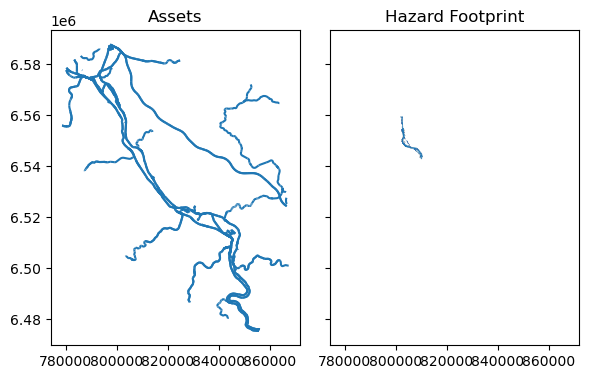

In [30]:
#plot assets and hazard map WARNING: can crash with many/complex geometries
#TODO move to utilities file
def subplots_asset_hazard(assets,hazard_map):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(6, 6), sharex=True, sharey=True)

    # Plot assets on the first subplot
    assets.plot(ax=axs[0])
    axs[0].set_title('Assets')

    # Plot hazard_map on the second subplot
    hazard_map.plot(ax=axs[1])
    axs[1].set_title('Hazard Footprint')

    plt.tight_layout()
    plt.show()

subplots_asset_hazard(assets, hazard_map)

In [15]:
 # make any invalid geometries valid:
print('Verifying validity of hazard footprint geometries')
hazard_map.geometry = hazard_map.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1) 


Verifying validity of hazard footprint geometries


In [16]:
# from def overlay_hazard_assets(df_ds,assets):
"""
Overlay hazard assets on a dataframe of spatial geometries.
Arguments:
    *df_ds*: GeoDataFrame containing the spatial geometries of the hazard data. 
    *assets*: GeoDataFrame containing the infrastructure assets.
Returns:
    *geopandas.GeoSeries*: A GeoSeries containing the spatial geometries of df_ds that intersect with the infrastructure assets.
"""
df_ds=hazard_map

# buffer assets
buffered_assets=buffer_assets(assets)
buffered_assets.head(n=2)


,osm_id,asset,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,other_tags,railway:traffic_mode,usage,geometry,buffered
0,4349787,rail,None,1435,no,None,None,25,yard,None,"""operator""=>""DB Netz AG"",""railway:lzb""=>""no"",""...","""passenger""",None,"LINESTRING (790210.378 6573898.727, 790156.098...","POLYGON ((790156.0979991176 6573925.229923702,..."
1,4349788,rail,Voreifelbahn,1435,no,None,yes,100,None,None,"""layer""=>""1"",""operator""=>""DB Netz AG"",""passeng...","""passenger""","""main""","LINESTRING (781441.686 6569223.078, 781466.889...","POLYGON ((781466.8892624202 6569173.650957938,..."


In [17]:

hazard_tree = shapely.STRtree(df_ds.geometry.values)
hazard_tree.geometries


array([<MULTIPOLYGON (((8.11e+05 6.54e+06, 8.11e+05 6.54e+06, 8.11e+05 6.54e+06, 8....>,
       <MULTIPOLYGON (((8.06e+05 6.55e+06, 8.06e+05 6.55e+06, 8.06e+05 6.55e+06, 8....>,
       <MULTIPOLYGON (((8.09e+05 6.55e+06, 8.09e+05 6.55e+06, 8.09e+05 6.55e+06, 8....>,
       <MULTIPOLYGON (((8.09e+05 6.55e+06, 8.09e+05 6.55e+06, 8.09e+05 6.55e+06, 8....>,
       <MULTIPOLYGON (((8.08e+05 6.55e+06, 8.08e+05 6.55e+06, 8.08e+05 6.55e+06, 8....>,
       <MULTIPOLYGON (((8.05e+05 6.55e+06, 8.05e+05 6.55e+06, 8.05e+05 6.55e+06, 8....>,
       <MULTIPOLYGON (((8.11e+05 6.54e+06, 8.11e+05 6.54e+06, 8.11e+05 6.54e+06, 8....>,
       <MULTIPOLYGON (((8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+...>,
       <MULTIPOLYGON (((8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+...>,
       <MULTIPOLYGON (((8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+...>,
       <MULTIPOLYGON (((8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+05 6.54e+06, 8.1e+...>,
       <MULTIPOLYGON 

In [18]:
# intersect assets with hazard tree
#[R3 - Elco] IF we stick to large multi-polygons, is the hazard tree necessary? This is the slowest step atm. Yes, it will still find the overlap, important for bigger dataset though not for sample.
if (shapely.get_type_id(assets.iloc[0].geometry) == 3) | (shapely.get_type_id(assets.iloc[0].geometry) == 6): # id types 3 and 6 stand for polygon and multipolygon
    print('polygon or multipolygon')
    output_1=hazard_tree.query(assets.geometry,predicate='intersects')    
else:
    output_2=hazard_tree.query(assets.buffered,predicate='intersects')

In [19]:
# Save and load hazard tree intersects to not run from scratch
f_name='intersect_'+hazard_name+'.csv'
save_output=data_path / 'interim' / f_name
save_output


WindowsPath('C:/Data/interim/intersect_flood_DERP_RW_H_4326_2080411370.csv')

In [20]:

df = pd.DataFrame(output_2)
df.to_csv(save_output, header=False, index=False)
output_2


array([[  43,  374,  374,  375,  375,  375,  377,  377,  377,  433,  433,
         433,  433,  620,  620, 1325, 1325, 1328, 1328, 1328, 1328, 1339,
        1339, 1339, 1343, 1343, 1343, 1348, 1348, 1348, 1351, 1351, 1548,
        1548, 2231, 2231, 2711, 2711, 2714, 2714, 2714, 2715, 2715, 2866,
        3309, 3309, 3309],
       [   0,    4,    1,    4,    0,    1,    0,    5,    1,    3,    2,
           7,    0,    0,    1,    3,    2,    3,    2,    7,    0,    4,
           0,    1,    0,    5,    1,    4,    0,    1,    4,    7,    0,
           1,    0,    1,    2,    0,    3,    2,    0,    3,    2,    0,
           3,    2,    0]], dtype=int64)

In [21]:
output_2_loaded = np.genfromtxt(save_output, delimiter=',', dtype=int)
output_2_loaded

array([[  43,  374,  374,  375,  375,  375,  377,  377,  377,  433,  433,
         433,  433,  620,  620, 1325, 1325, 1328, 1328, 1328, 1328, 1339,
        1339, 1339, 1343, 1343, 1343, 1348, 1348, 1348, 1351, 1351, 1548,
        1548, 2231, 2231, 2711, 2711, 2714, 2714, 2714, 2715, 2715, 2866,
        3309, 3309, 3309],
       [   0,    4,    1,    4,    0,    1,    0,    5,    1,    3,    2,
           7,    0,    0,    1,    3,    2,    3,    2,    7,    0,    4,
           0,    1,    0,    5,    1,    4,    0,    1,    4,    7,    0,
           1,    0,    1,    2,    0,    3,    2,    0,    3,    2,    0,
           3,    2,    0]])

In [22]:

intersected_assets=output_2_loaded
# overlay assets:
overlay_assets = pd.DataFrame(intersected_assets.T,columns=['asset','hazard_point'])
overlay_assets.tail(n=30)

,asset,hazard_point
17,1328,3
18,1328,2
19,1328,7
20,1328,0
21,1339,4
22,1339,0
23,1339,1
24,1343,0
25,1343,5
26,1343,1


In [23]:
#[Q4 - Elco] - should we use the upper or lower bound for flooding depth? And the bigger question, I can't understand why the result is the same with both
# convert dataframe to numpy array
#hazard_numpified = hazard_map.to_numpy() # modified to drop data
hazard_numpified = hazard_map.drop('w_depth_u', axis=1).to_numpy() 
hazard_numpified

#changed for upper and lower bounds
hazard_numpified_u = hazard_map.drop('w_depth_l', axis=1).to_numpy() 
hazard_numpified_l = hazard_map.drop('w_depth_u', axis=1).to_numpy()
hazard_numpified_list=[hazard_numpified_l, hazard_numpified_u] 


In [24]:
#TODO does not return tuple but list of the same length as maxdams.
def get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - Asset-specific information, including hazard points (asset[1]['hazard_point']).  
        *flood_numpified*: NumPy array representing flood hazard information.
        *asset_geom*: Shapely geometry representing the spatial coordinates of the asset.
        *curve*: Pandas DataFrame representing the curve for the asset type.
        *maxdam*: Maximum damage value. #maxdams list of maxdam
    Returns:
        *tuple*: A tuple containing the asset index or identifier and the calculated damage.
    """
    
    # find the exact hazard overlays:
    get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

    # estimate damage
    if len(get_hazard_points) == 0: # no overlay of asset with hazard
        return 0
    
    else:
        if asset_geom.geom_type == 'LineString':
            overlay_meters = shapely.length(shapely.intersection(get_hazard_points[:,1],asset_geom)) # get the length of exposed meters per hazard cell
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_meters*maxdam_asset) for maxdam_asset in maxdams] #return asset number, total damage for asset number (damage factor * meters * max. damage)
        
        elif asset_geom.geom_type in ['MultiPolygon','Polygon']:
            overlay_m2 = shapely.area(shapely.intersection(get_hazard_points[:,1],asset_geom))
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_m2*maxdam_asset) for maxdam_asset in maxdams]
        
        elif asset_geom.geom_type == 'Point':
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*maxdam_asset) for maxdam_asset in maxdams]


In [25]:
# Inspection code, to be removed
#    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

#hazard_numpified_l[asset[1]['hazard_point'].values][:,1]


In [26]:
vul_data = data_path / 'Vulnerability'
maxdamxx = pd.read_excel(vul_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])

In [27]:
# WITH LOWER BOUND OF FLOOD DEPTH
#[Q5 - Elco] Why is this run for each infrastructure curve and why for each maxdam value? Filtering only the selected maxdam value through maxdamxx variable
maxdam_types = {} #TODO use or remove?

for infra_curve in infra_curves:
    maxdams_filt=maxdamxx[maxdamxx['ID number']==infra_curve[0]]['Amount']
    print('Damage curve ID (infra_curve[0]): ', end='')
    print(infra_curve[0])
    if not infra_curve[0] in curve_types[infra_type]:continue
    # get curves
    curve = infra_curves[infra_curve[0]]
    hazard_intensity = curve.index.values
    fragility_values = (np.nan_to_num(curve.values,nan=(np.nanmax(curve.values)))).flatten()       
    collect_inb = {}
    for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
        try:
            asset_type = type_dict[asset[0]]
        except KeyError: 
            print(f'Passed asset {asset[0]}')
            continue
        if not infra_curve[0] in curve_types[asset_type]: 
            collect_inb[asset[0]] = 0
            print(f'Asset {asset[0]}: No vulnerability data found')

        if np.max(fragility_values) == 0:
            collect_inb[asset[0]] = 0  
            print(f'Asset {asset[0]}: Fragility = 0')
        else:
            asset_geom = geom_dict[asset[0]]
                            
            #collect_inb[asset[0]] = get_damage_per_asset(asset,hazard_numpified_l,asset_geom,hazard_intensity,fragility_values,maxdams_filt)
            collect_inb[asset[0]] = tuple(get_damage_per_asset(asset,h_numpified,asset_geom,hazard_intensity,fragility_values,maxdams_filt)[0] for h_numpified in hazard_numpified_list)

    print(collect_inb)
    collect_output[hazard_name,infra_curve[0]] = pd.DataFrame.from_dict(collect_inb, orient='index')#.sum(axis=1)
    # collect_output[hazard_name,infra_curve[0],maxdam] = pd.DataFrame.from_dict(collect_inb).sum()
#break # remove break after testing

Damage curve ID (infra_curve[0]): F8.1


100%|██████████| 19/19 [00:14<00:00,  1.30it/s]

{43: (0.0, 6804.70524910867), 374: (35681.36614604254, 183320.07231032426), 375: (12694.772779722756, 91773.82987210897), 377: (10501.288663949334, 47721.054899095056), 433: (1694688.3299544218, 5169602.150739019), 620: (4938.013851203248, 11007.983632391166), 1325: (141142.7466311752, 678080.0877499741), 1328: (726643.7091104591, 2471198.7550438214), 1339: (14663.35847214106, 101679.47606096763), 1343: (10505.763125255147, 38957.769375767646), 1348: (112247.01885146243, 397397.07885508763), 1351: (47372.74474048824, 184343.02015601346), 1548: (2454.9455722645575, 12274.727126641936), 2231: (53660.13253225429, 343759.40683026717), 2711: (16452.33871267755, 48776.64195511594), 2714: (19408.797030851336, 84722.06047424386), 2715: (793078.6542875242, 3457412.3684191313), 2866: (0.0, 5036.91179721698), 3309: (10273.651173549417, 21173.019442623066)}
Damage curve ID (infra_curve[0]): F8.2
Damage curve ID (infra_curve[0]): F8.3
Damage curve ID (infra_curve[0]): F8.4
Damage curve ID (infra_cu

In [28]:
collect_output[hazard_name,infra_curve[0]] = pd.DataFrame.from_dict(collect_inb, orient='index')#.sum(axis=1)
collect_output

{('flood_DERP_RW_H_4326_2080411370',
  'F8.1'):                  0             1
 43    0.000000e+00  6.804705e+03
 374   3.568137e+04  1.833201e+05
 375   1.269477e+04  9.177383e+04
 377   1.050129e+04  4.772105e+04
 433   1.694688e+06  5.169602e+06
 620   4.938014e+03  1.100798e+04
 1325  1.411427e+05  6.780801e+05
 1328  7.266437e+05  2.471199e+06
 1339  1.466336e+04  1.016795e+05
 1343  1.050576e+04  3.895777e+04
 1348  1.122470e+05  3.973971e+05
 1351  4.737274e+04  1.843430e+05
 1548  2.454946e+03  1.227473e+04
 2231  5.366013e+04  3.437594e+05
 2711  1.645234e+04  4.877664e+04
 2714  1.940880e+04  8.472206e+04
 2715  7.930787e+05  3.457412e+06
 2866  0.000000e+00  5.036912e+03
 3309  1.027365e+04  2.117302e+04,
 ('flood_DERP_RW_H_4326_2080411370',
  'F8.8'):                  0             1
 43    0.000000e+00  6.804705e+03
 374   3.568137e+04  1.833201e+05
 375   1.269477e+04  9.177383e+04
 377   1.050129e+04  4.772105e+04
 433   1.694688e+06  5.169602e+06
 620   4.938014e+03  

In [ ]:
overlay_assets

In [ ]:
assets.loc[1759]

In [ ]:
import matplotlib.pyplot as plt

# Initialize empty lists for asset lengths and damages
asset_lengths = []
damages1_per_m = []
damages2_per_m = []

# Iterate over all assets
for asset, asset_geom in geom_dict.items():
    # If the asset has damages
    if asset in collect_inb:
        # Add the length of the asset and the damage to the lists
        asset_lengths.append(asset_geom.length)
        damage1, damage2 = tuple(d / asset_geom.length for d in collect_inb[asset])
        damages1_per_m.append(damage1)
        damages2_per_m.append(damage2)

# Create a scatter plot for the first damage value
plt.scatter(asset_lengths, damages1_per_m, color='blue', label='Damage 1', s=2)

# Create a scatter plot for the second damage value
plt.scatter(asset_lengths, damages2_per_m, color='red', label='Damage 2', s=2)

plt.xlabel('Asset Length')
plt.ylabel('Damage/m')
plt.title('Damage/m vs Asset Length')
plt.legend()
plt.show()

END OF TESTING, old code begins here

In [ ]:
def country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type):
    

    # get country osm data
    #data_loc = country_download(country_code)
    
    # get infrastructure data:
    #assets = ex.extract_cis(data_loc, infra_type)

    # use pre-downloaded data as source
    rail_track_file=data_path / 'Exposure' / 'raw_rail_track_study_area_KOBLENZ_BONN.geojson'
    assets = gpd.read_file(rail_track_file)
    
    # convert assets to epsg3857
    assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
    
    if infra_type == 'road':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'highway' : 'asset'})
    elif infra_type == 'rail':
        #TODO Consider non LineString assets and distinguish between types of tracks. Also stations, switches, etc. (watch out - some max damages already consider them within the bulk sum unit cost)
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'railway' : 'asset'})
    elif infra_type == 'education':
        assets = assets.rename(columns={'building' : 'asset'})
        assets = assets.reset_index(drop=True)
        assets = remove_contained_points(assets)

        #convert points to polygons
        assets.loc[assets.geom_type == 'Point','geometry'] = assets.loc[assets.geom_type == 'Point'].buffer(
                                                                        distance=np.sqrt(assets.loc[assets.geom_type == 'MultiPolygon'].area.median())/2, cap_style='square')

    elif infra_type == 'air':
        assets = assets.rename(columns={'aeroway' : 'asset'})
        
    
    # create dicts for quicker lookup
    geom_dict = assets['geometry'].to_dict()
    type_dict = assets['asset'].to_dict()
    print('Dictionary of asset types:')
    print(type_dict)
    
    # read hazard data
    hazard_data_list = read_hazard_data(data_path,hazard_type)
    
    # read vulnerability and maxdam data:
    infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type,infra_type)
    print(f'Found matching infrastructure curves for {infra_type}:')
    print(infra_curves.head())
    curve_types = {'primary': ['F7.1', 'F7.2'],
                  'secondary': ['F7.3', 'F7.4'],
                  'rail': ['F8.1']}



    # start analysis
    print('--ANALYSIS START--') 
    print(f'{country_code} runs for {infra_type} for {hazard_type} for {len(hazard_data_list)} maps for {len(infra_curves.T)*len(maxdams)} combinations')
    
    if hazard_type in ['windstorm','earthquake','landslide']:
        # load country geometry file and create geometry to clip
        ne_countries = gpd.read_file(data_path / "natural_earth" / "ne_10m_admin_0_countries.shp")
        bbox = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry.envelope.values[0].bounds


    collect_output = {}
    for single_footprint in hazard_data_list: #tqdm(hazard_data_list,total=len(hazard_data_list)):
        hazard_name = single_footprint.parts[-1].split('.')[0]
        print(f'Reading hazard map: {hazard_name}')
        
        # load hazard map
        if hazard_type in ['pluvial','fluvial']:
            hazard_map = read_flood_map(single_footprint)
        elif hazard_type in ['windstorm']:
             hazard_map = read_windstorm_map(single_footprint,bbox)
        elif hazard_type in ['earthquake']:
             hazard_map = read_earthquake_map(single_footprint)
        elif hazard_type in ['landslide']:
             hazard_map = read_landslide_map(single_footprint)
         
        # convert hazard data to epsg 3857
        if '.shp' in str(hazard_map):
            hazard_map=gpd.read_file(hazard_map).to_crs(3857)
        else:
            hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)
                  
        # make any invalid geometries valid:
        print('Verifying validity of hazard footprint geometries')
        hazard_map.geometry = hazard_map.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1) 


        # overlay assets:
        print('Overlaying assets')
        overlay_assets = pd.DataFrame(overlay_hazard_assets(hazard_map,buffer_assets(assets)).T,columns=['asset','hazard_point'])
        print('Asset overlay success!, numpifying array')
        # convert dataframe to numpy array
        hazard_numpified = hazard_map.to_numpy() 

        maxdam_types = {} #TODO use or remove?
        
        for infra_curve in infra_curves:
            print('Damage curve ID (infra_curve[0]): ', end='')
            print(infra_curve[0])
            if not infra_curve[0] in curve_types[infra_type]:continue
            # get curves
            curve = infra_curves[infra_curve[0]]
            hazard_intensity = curve.index.values
            fragility_values = (np.nan_to_num(curve.values,nan=(np.nanmax(curve.values)))).flatten()       
            collect_inb = {}
            for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
                    asset_type = type_dict[asset[0]]
            if not infra_curve[0] in curve_types[asset_type]: 
                collect_inb[asset_type] = 0

            if np.max(fragility_values) == 0:
                collect_inb[asset_type] = 0  
            else:
                asset_geom = geom_dict[asset[0]]
                                
                collect_inb[asset_type] = get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams)
            print(collect_inb)
            collect_output[hazard_name,infra_curve[0]] = pd.DataFrame.from_dict(collect_inb, orient='index').sum(axis=1)
            # collect_output[hazard_name,infra_curve[0],maxdam] = pd.DataFrame.from_dict(collect_inb).sum()
        #break # remove break after testing
    return collect_output

In [ ]:
# List of critical infrastructure systems to process
cis = ['healthcare', 'education', 'gas', 'oil', 'telecom', 'water', 'wastewater', 'power', 'rail', 'road', 'air']

In [ ]:
infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type,infra_type)

In [ ]:
maxdams

In [ ]:
infra_curves.columns.get_level_values(0)

In [ ]:
print(data_path,country_code,infra_type,hazard_type)

In [ ]:
test2 = country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type)

In [ ]:
test2['DERP_RW_M_4326_subsample_valid']

In [ ]:
test1 = country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type)

In [ ]:
sum([9053.938718708601, 1774250.6544519751, 17446798.102111086, 412845.8273133607, 29441.874828862572, 36802.34353607822, 353302.4979463509, 441628.1224329386, 1472093.7414431286, 1491418.0737840198, 413406.23831245454, 200247254.95903745, 200247254.95903745, 213597071.95630658, 320285.81997394946, 80071.45499348736])

In [ ]:
test1

In [ ]:
test = country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type)

In [ ]:
test